In [1]:
import pandas as pd
from data_prep.dont_patronize_me import DontPatronizeMe
from data_prep.preproc import PreProcessor

pp = PreProcessor()

[nltk_data] Downloading package stopwords to
[nltk_data]     /homes/yz10519/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dev_predictions = pd.read_csv('dev.txt', header=None)
dev_labels = pp.raw_dev
dpm = DontPatronizeMe("data", "data")
dpm.load_task1()
pcl_dataset = dpm.train_task1_df

In [3]:
pcl_dataset["length"] = pcl_dataset["text"].apply(lambda x: len(x.split()))
filter_pcl_df = pcl_dataset[["par_id", "label", "orig_label", "length", "keyword"]]

In [4]:
dev_labels_df = dev_labels[["par_id", "label"]]
dev_labels_df["pred"] = dev_predictions[0]
dev_labels_df["par_id"] = dev_labels_df["par_id"].astype(int)
filter_pcl_df["orig_label"] = filter_pcl_df["orig_label"].astype(int)

/tmp/ipykernel_1168208/2469248964.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_labels_df["pred"] = dev_predictions[0]
/tmp/ipykernel_1168208/2469248964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_labels_df["par_id"] = dev_labels_df["par_id"].astype(int)
/tmp/ipykernel_1168208/2469248964.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [5]:
dev_labels_df = dev_labels_df.join(filter_pcl_df, on=["par_id"], how="inner", rsuffix="_pcl")
dev_labels_df = dev_labels_df.drop(columns=["par_id_pcl"])

In [6]:
dev_labels_df

,par_id,label,pred,label_pcl,orig_label,length,keyword
0,4046,1,0,0,0,88,vulnerable
1,1279,1,1,0,0,56,migrant
2,8330,1,0,0,0,28,women
3,4063,1,1,0,0,53,women
4,4089,1,0,1,3,55,women
...,...,...,...,...,...,...,...
2089,10462,0,0,0,0,37,refugee
2090,10463,0,0,0,0,38,disabled
2091,10464,0,0,0,1,64,women
2092,10465,0,0,0,0,43,vulnerable


In [7]:
from sklearn.metrics import f1_score

f1_scores = {}
for data_type in [0, 1, 2, 3, 4]:
    actual = dev_labels_df[dev_labels_df['orig_label'] == data_type]['label']
    predicted = dev_labels_df[dev_labels_df['orig_label'] == data_type]['pred']
    f1_scores[data_type] = f1_score(actual, predicted, average='binary', pos_label=1)

f1_scores


{0: 0.5512820512820513,
 1: 0.5945945945945946,
 2: 0.0,
 3: 0.7,
 4: 0.7142857142857143}

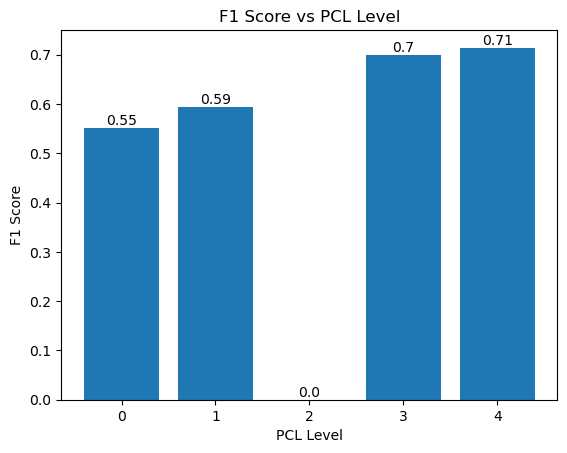

In [9]:
import matplotlib.pyplot as plt

plt.bar(f1_scores.keys(), f1_scores.values())
plt.xlabel('PCL Level')
plt.ylabel('F1 Score')
plt.title('F1 Score vs PCL Level')

# Add values on top of the bars
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.savefig('plots/f1_scores_pcl_level_plot.png')
plt.show()

In [10]:
f1_scores = {}

actual = dev_labels_df[dev_labels_df['length'] > 125]['label']
predicted = dev_labels_df[dev_labels_df['length'] > 125]['pred']
f1_scores["long"] = f1_score(actual, predicted)

actual = dev_labels_df[(dev_labels_df['length'] >= 75) & (dev_labels_df['length'] <= 125)]['label']
predicted = dev_labels_df[(dev_labels_df['length'] >= 75) & (dev_labels_df['length'] <= 125)]['pred']
f1_scores["medium"] = f1_score(actual, predicted)

actual = dev_labels_df[dev_labels_df['length'] < 75]['label']
predicted = dev_labels_df[dev_labels_df['length'] < 75]['pred']
f1_scores["short"] = f1_score(actual, predicted, average='macro')

f1_scores

{'long': 0.4, 'medium': 0.6545454545454545, 'short': 0.7561040872299151}

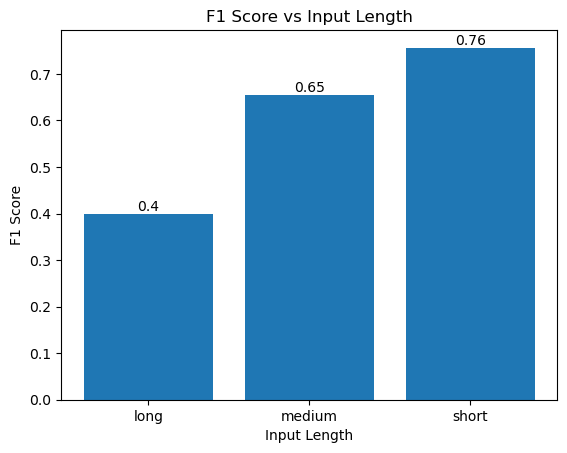

In [11]:
plt.bar(f1_scores.keys(), f1_scores.values())
plt.xlabel('Input Length')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Input Length')

# Add values on top of the bars
for i, v in enumerate(f1_scores.values()):
    plt.text(i, v, str(round(v, 2)), ha='center', va='bottom')

plt.savefig('plots/f1_scores_length_plot.png')
plt.show()


In [12]:
f1_scores = {}
for keyword in dev_labels_df['keyword'].unique():
    actual = dev_labels_df[dev_labels_df['keyword'] == keyword]['label']
    predicted = dev_labels_df[dev_labels_df['keyword'] == keyword]['pred']
    f1_scores[keyword] = f1_score(actual, predicted, average='binary', pos_label=1)

f1_scores

{'vulnerable': 0.6037735849056604,
 'migrant': 0.5641025641025641,
 'women': 0.43902439024390244,
 'refugee': 0.37037037037037035,
 'homeless': 0.5625,
 'disabled': 0.6896551724137931,
 'hopeless': 0.7222222222222222,
 'in-need': 0.41379310344827586,
 'immigrant': 0.6153846153846154,
 'poor-families': 0.6086956521739131}

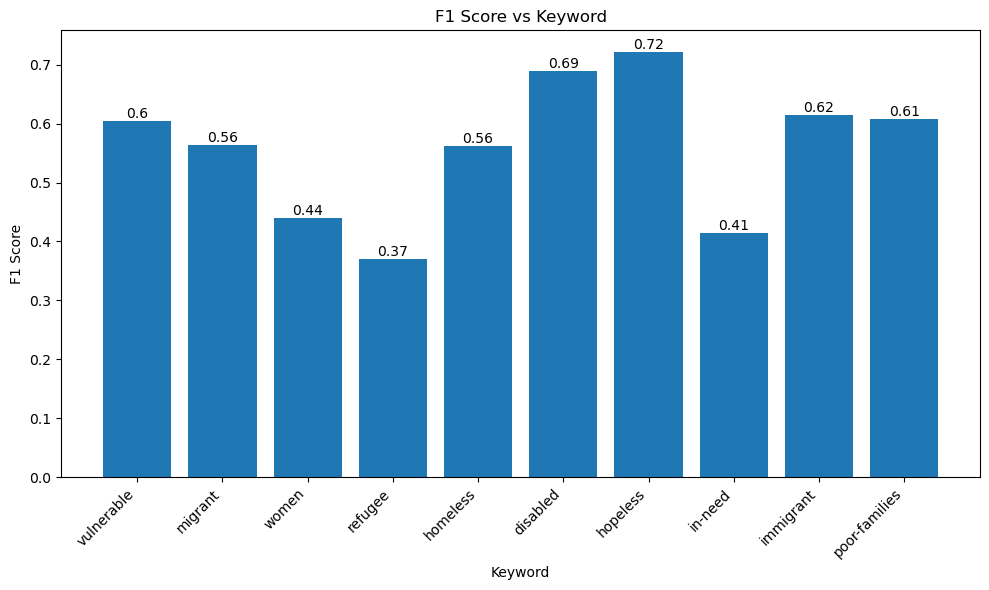

In [14]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.bar(f1_scores.keys(), f1_scores.values())
plt.xlabel('Keyword')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Keyword')

# Rotate x-axis labels diagonally
plt.xticks(rotation=45, ha='right')

# Add values on top of the bars
for keyword, score in f1_scores.items():
    plt.text(keyword, score, str(round(score, 2)), ha='center', va='bottom')

plt.tight_layout()  # Adjust the margins
plt.savefig('plots/f1_scores_keyword_plot.png')
plt.show()
